# Minimizing the radius of an extremal EoS -- varying $\epsilon_{\Delta}$

In [1]:
# For measuring runtime
import time
start_time = time.time()

In [2]:
import numpy as np
from scipy.integrate import solve_ivp, odeint, quad
from astropy.constants import G, c
from numpy import pi
import astropy.units as u
import matplotlib.pyplot as plt
import sys
import math
np.set_printoptions(threshold=sys.maxsize)
from scipy import optimize
from sympy import symbols, diff

In [3]:
# Using natural units
# 197 MeV * fm = 1
# 1 fm = 1 / (197 MeV)
# 3e8 m = 1 s
# 3e8 m / s = 1
# 1 J = 1 kg * (m / s)^2
# 1 J = 1 / 9e16 kg

natural = [(u.MeV, u.fm ** (-1), lambda fm_inverse: 1 / 197 * fm_inverse, lambda MeV: 197 * MeV),
           (u.m, u.s, lambda s: 1 / c.value * s, lambda m: c.value * m),
           (u.kg, u.J, lambda J: c.value ** 2 * J, lambda kg: 1 / c.value ** 2 * kg),
           (u.m / u.s, u.dimensionless_unscaled, lambda dimensionless: 1 / c.value * dimensionless, lambda v: c.value * v),
           (u.fm, u.MeV ** (-1), lambda MeV_inverse: 1 / 197 * MeV_inverse, lambda fm: 197 * fm)
          ]

G = (G.value * (1 * u.m / u.s).to(u.dimensionless_unscaled, equivalencies = natural) ** 2 * (1 * u.m).to(u.fm).to(1 / u.MeV, equivalencies = natural) / (1 * u.kg).to(u.J, equivalencies = natural).to(u.MeV))
print(G)
G = G.value

6.7199660587126e-45 1 / MeV2


## Functions to find numerical EoS arrays for Fermi gas and strong interaction given some number density (in natural units)

In [4]:
# Non-rest-mass energy E
def find_E(num_density):
    result = a * (num_density / n_0) ** alpha + b * (num_density / n_0) ** beta
    return result

# Energy density epsilon
def find_epsilon(num_density):
    E = find_E(num_density)
    result = num_density * (E + m_N)
    return result

# Chemical potential
def find_chem_potential(num_density):
    result = a * (alpha + 1) * (num_density / n_0) ** alpha + b * (beta + 1) * (num_density / n_0) ** beta + m_N
    return result

# Pressure
def find_pressure(num_density, epsilon_D):
    epsilon = find_epsilon(num_density)
    chem_potential = find_chem_potential(num_density)

    epsilon_Delta = epsilon_D * u.MeV / (1 * u.fm).to(1 / u.MeV, equivalencies = natural) ** 3
    
    num_density_c = num_density_from_energy_density(epsilon_c.value) * u.MeV ** 3
    chem_potential_c = find_chem_potential(num_density_c)
    pressure_c = - epsilon_c + chem_potential_c * num_density_c
    
    # Piece-wise extremal EoS
    if epsilon.value < epsilon_c.value:
        result = - epsilon + chem_potential * num_density    # Gandolfi nuclear EoS
    else:
        if epsilon.value < epsilon_Delta.value:
            result = pressure_c    # Flat EoS
        else:
            result = pressure_c + (epsilon - epsilon_Delta)    # EoS slope = 1
    
    return result

In [5]:
# Finding number density as a function of energy density

def energy_density_minus_target_epsilon(n, target_epsilon):
    n = n * u.MeV ** 3
    result = find_epsilon(n).value - target_epsilon
    return result

def num_density_from_energy_density(epsilon):
    b = 10 ** 12
    if energy_density_minus_target_epsilon(0, epsilon) > 0:
        print(f"find_epsilon is {find_epsilon(0 * u.MeV ** 3)} and epsilon is {epsilon}.")
        return
    result = optimize.brentq(energy_density_minus_target_epsilon,
                             0,
                             b,
                             args = (epsilon,))
    return result

## Plotting the EoS

In [6]:
# epsilon = []
# pressure = []

# n = np.logspace(-0.3, 1, num = 200) * n_0

# for num_density in n:
#     epsilon_in_MeV = find_epsilon(num_density).value
#     epsilon_in_MeV_and_fm = epsilon_in_MeV * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
#     epsilon.append(epsilon_in_MeV_and_fm.value)
#     pressure_in_MeV = find_pressure(num_density, epsilon_D).value
#     pressure_in_MeV_and_fm = pressure_in_MeV * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
#     pressure.append(pressure_in_MeV_and_fm.value)

In [7]:
# fig, ax = plt.subplots(figsize = (8, 8))

# epsilon_c_MeV_and_fm = epsilon_c * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
# epsilon_delta_MeV_and_fm = epsilon_delta * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
# ax.set_title("Equation of state", fontsize = 15);
# ax.set_xlabel(r"$\mathrm{Energy\,density}\,\epsilon\,\left(\mathrm{MeV/\,fm^3}\right)$", fontsize = 15);
# ax.set_ylabel(r"$\mathrm{Pressure\,\left(MeV/\,fm^3\right)}$", fontsize = 15);
# ax.set_xlim(0, epsilon_delta_MeV_and_fm.value + 25);
# ax.set_ylim(0, 25);
# ax.plot(epsilon, pressure, label = "EoS");
# ax.axvline(x = epsilon_c_MeV_and_fm.value, color = "red", linewidth = 0.5, label = r"$\epsilon_{c}=150\,\mathrm{MeV/\,fm^3}$");
# ax.axvline(x = epsilon_delta_MeV_and_fm.value, color = "green", linewidth = 0.5, label = r"$\epsilon_{\Delta}=650\,\mathrm{MeV/\,fm^3}$");
# ax.legend(fontsize = 15);

# plt.savefig("Piecewise_EoS.pdf", bbox_inches = "tight");
# plt.savefig("Piecewise_EoS.jpg", bbox_inches = "tight");

## Generalized TOV

In [8]:
# r = distance from center
# m = cumulative mass enclosed within distance r from center
# p = pressure at distance r from center
# epsilon = energy density at distance r from center

# TOV coded to be compatible w/ cgs units, but can't explicitly give units in code b/c solve_ivp() throws errors

def TOV(r, p_and_m, epsilon_D):
    p = p_and_m[0]
    m = p_and_m[1]
    if num_density_from_pressure(p, r, epsilon_D) is None:
        return [0, 0]
    n = num_density_from_pressure(p, r, epsilon_D) * u.MeV ** 3
    epsilon = find_epsilon(n).value
    print(f"number density is {n}")
    rel_factors = (1 + p / epsilon) * (1 + 4 * pi * r ** 3 * p / m) * (1 - 2 * G * m / r) ** (-1)
    p_result = - G * epsilon * m / r ** 2 * rel_factors
    m_result = 4 * pi * r ** 2 * epsilon
    return [p_result, m_result]

In [9]:
# Finding number density as a function of pressure

def pressure_minus_target_p(n, target_p, epsilon_D):
    n = n * u.MeV ** 3
    result = find_pressure(n, epsilon_D).value - target_p
    return result

# Global variable so it can be modified when n_high needs to be increased later
pressure_brentq_b = 10 ** 8

def num_density_from_pressure(p, r, epsilon_D):
    if pressure_minus_target_p(0, p, epsilon_D) > 0:
        print(f"Distance from center is {(r / u.MeV).to(u.fm, equivalencies = natural).to(u.km)}, w/ find_pressure {find_pressure(0 * u.MeV ** 3, epsilon_D)} and p {p}.")
        return
    result = optimize.brentq(pressure_minus_target_p,
                             0,
                             pressure_brentq_b,
                             args = (p, epsilon_D))
    return result

### Setting central cumulative mass initial condition

In [10]:
def M_from_r_and_rho(r, rho):
    result = 4 * pi * rho * r ** 3 / 3
    return result

### TOV solver function

In [11]:
# Keep this for all EoS

def solve_TOV(n_central, p_central, epsilon_D):
    epsilon_central = find_epsilon(n_central * u.MeV ** 3).value
    m_central = M_from_r_and_rho(small_r, epsilon_central)
    def reached_surface(t, y, *args):
        return y[0]

    reached_surface.terminal = True
    reached_surface.direction = -1
    
    solution = solve_ivp(TOV,
                         [small_r, R_attempt],
                         [p_central, m_central],
                         events = reached_surface,
                         args = (epsilon_D,)
                        )

    distance_from_center = (solution.t / u.MeV).to(u.fm, equivalencies = natural).to(u.km)
    print(f"Mass is {(solution.y[1][-1] * u. MeV).to(u.J).to(u.kg, equivalencies = natural).to(u.solMass):.3f}.")
    cumulative_mass = (solution.y[1] * u.MeV).to(u.J).to(u.kg, equivalencies = natural).to(u.solMass)
    pressure = solution.y[0]

    result = distance_from_center, cumulative_mass, pressure
    return result

### Setting constants for solving TOV

In [12]:
# Everything in natural units unless otherwise specified
# r_small cannot be 0 b/c it would cause a singularity.

small_r = (0.1 * u.km).to(u.fm).to(1 / u.MeV, equivalencies = natural).value
m_N = 939.565 * u.MeV    # Natural units
n_0 = 0.16 / (1 * u.fm).to(1 / u.MeV, equivalencies = natural) ** 3    # Nuclear saturation density

# Setting nuclear parameters (from Gandolfi et. al.)
a = 13.0 * u.MeV
alpha = 0.49
b = 3.21 * u.MeV
beta = 2.47

# Setting critical energy density corresponding to n_0 for piece-wise EoS
epsilon_c_value = 150    # In MeV / fm^3
epsilon_c = epsilon_c_value * u.MeV / (1 * u.fm).to(1 / u.MeV, equivalencies = natural) ** 3
# Note: need to specify epsilon_delta before solving TOV for piece-wise EoS

### Horizontal axis scale

In [13]:
# Everything in natural units unless otherwise specified

R_attempt = (100 * u.km).to(u.fm).to(1 / u.MeV, equivalencies = natural).value

### Solving TOV example

In [14]:
# # Nuclear saturation number density is 0.16 fm^(-3)
# n_central = 7 * n_0
# print(f"{n_0:.3e}")
# p_central = find_pressure(n_central, epsilon_D).value
# print(f"p_central is {p_central}")
# distance_from_center, cumulative_mass, pressure = solve_TOV(n_central.value, p_central)

In [15]:
# fig, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 8))

# ax1.set_title("Cumulative mass vs distance from center", fontsize = 18);
# ax1.set_xlabel("Distance from center (km)", fontsize = 18);
# ax1.set_ylabel(r"Cumulative mass ($\mathrm{M_{\odot}}$)", fontsize = 18);
# # ax1.set_xlim(0, 20);
# # ax1.set_ylim(0, 0.6);
# ax1.plot(distance_from_center, cumulative_mass);
# ax2.set_title("Pressure vs distance from center", fontsize = 18);
# ax2.set_xlabel("Distance from center (km)", fontsize = 18);
# ax2.set_ylabel(r"Pressure $\left(\mathrm{MeV/\,fm^3}\right)$", fontsize = 18);
# # ax2.set_xlim(0, 20);
# ax2.plot(distance_from_center, pressure);

In [16]:
# print(f"Mass is {np.max(cumulative_mass):.2f}.")

## Finding radius for $2.00\,M_{\odot}$

In [17]:
# Function to find mass and radius for particular number density
def find_mass_radius(num_density, epsilon_D):
    # Solving TOV
    p_central = find_pressure(num_density, epsilon_D).value
    distance_from_center, cumulative_mass, _ = solve_TOV(num_density.value, p_central, epsilon_D)
    print(f"Solved TOV for epsilon_delta {epsilon_D} MeV / fm^3")

    # Removing NaN and inf values
    cumulative_mass = cumulative_mass[~np.isnan(cumulative_mass)]
    cumulative_mass = cumulative_mass[~np.isinf(cumulative_mass)]

    # Picking out single values
    mass = cumulative_mass[-1].value
    radius = distance_from_center[-1].value
    
    return mass, radius

In [18]:
# Function to find mass residual and closest density
def find_mass_residual(mass_low, mass_high, n_low, n_high):
    if target_mass - mass_low < mass_high - target_mass:
        mass_closest = mass_low
        n_closest = n_low
    else:
        mass_closest = mass_high
        n_closest = n_high
    
    mass_residual = target_mass - mass_closest

    return mass_residual, n_closest

In [19]:
# Setting initial densities and default increment direction
n_low = n_0    # Undershoot
n_high = 8 * n_0    # Overshoot
direction = 1    # For low mass_high errors: +1 means increase, -1 means decrease

In [20]:
# Function to find the radius of a 2.00 solar mass neutron star using linear interpolation
def find_radius(epsilon_D):
    # Specifying that we're working w/ external variables
    global n_low
    global n_high
    global pressure_brentq_b
    global direction
    
    print(f"n_low is {n_low}")
    print(f"n_high is {n_high}")
    
    # Initial mass and radius outputs
    mass_low, radius_low = find_mass_radius(n_low, epsilon_D)
    mass_high, radius_high = find_mass_radius(n_high, epsilon_D)
    
    # Ensuring there's not a problem
    if target_mass - mass_low < 0:
        print("Error: mass_low greater than target mass")
        raise KeyboardInterrupt
    
    # Initializing the empty arrays of previous mass_high and n_high values to be filled in the loop
    previous_mass_highs = []
    previous_n_highs = []

    # Saving initial mass_high and n_high
    previous_mass_highs.append(mass_high)
    previous_n_highs.append(n_high.copy())
    print(f"previous_mass_highs: {previous_mass_highs}")
    print(f"previous_n_highs: {previous_n_highs}")
    
    while mass_high - target_mass < 0:
        print("Error: mass_high less than target mass")
        
        # Note: both increments below are 1/8 of the initial values
        n_high += speed * direction * n_0    # Increasing n_high to avoid mass_high error, when necessary
        pressure_brentq_b += direction * 1.25 * 10 ** 7    # Increasing pressure_brentq_b when n_high increased to avoid brentq sign error
        print(f"n_high is {n_high}")
        
        mass_high, radius_high = find_mass_radius(n_high, epsilon_D)

        # Saving previous mass_high and n_high in local arrays in case direction needs reversing
        previous_mass_highs.append(mass_high)
        previous_n_highs.append(n_high.copy())
        print(f"previous_mass_highs: {previous_mass_highs}")
        print(f"previous_n_highs: {previous_n_highs}")
        
        # Reversing direction of increments if default incrementing stops working
        if mass_high < previous_mass_highs[-2]:
            direction *= -1

            # Checking for oscillation
            if np.size(previous_mass_highs) > 2:
                # Finding 3 calculated points in oscillation
                y2 = np.max(previous_mass_highs)
                max_index = np.where(previous_mass_highs == y2)[0][0]
                x2 = previous_n_highs[max_index].value
                x1 = previous_n_highs[max_index - 1].value
                y1 = previous_mass_highs[max_index - 1]
                x3 = previous_n_highs[max_index + 1].value
                y3 = previous_mass_highs[max_index + 1]
                print(f"x1 = {x1}")
                print(f"x2 = {x2}")
                print(f"x3 = {x3}")
                print(f"y1 = {y1}")
                print(f"y2 = {y2}")
                print(f"y3 = {y3}")

                # Fitting parabola parameters
                b_parab = ((y3 - y2) * (x2 ** 2 - x1 ** 2) / (x2 ** 2 - x3 ** 2) + y2 - y1) / ((x1 ** 2 - x2 ** 2) / (x2 + x3) + x2 - x1)
                a_parab = (b_parab * x3 - y3 - b_parab * x2 + y2) / (x2 ** 2 - x3 ** 2)
                c_parab = y1 - a_parab * x1 ** 2 - b_parab * x1
                print(f"a_parab = {a_parab}")
                print(f"b_parab = {b_parab}")
                print(f"c_parab = {c_parab}")

                # Calculating maximum mass from parabola
                x_max = - b_parab / 2 / a_parab
                print(f"x_max = {x_max}")
                max_parab = a_parab * x_max ** 2 + b_parab * x_max + c_parab
                print(f"max_parab = {max_parab}")

                # Checking whether maximum mass from parabola is less than or greater than 2.00 solar masses
                if max_parab < target_mass:
                    radius_result = None
                    epsilon_delta_sub_2 = epsilon_D * u.MeV / (1 * u.fm) ** 3    # In sub-2 case, current value of epsilon_delta should be noted as such
                    return radius_result, epsilon_delta_sub_2

                # In over-2 case, set n_high using parabola
                else:
                    d_parab = c_parab - target_mass    # For finding where mass = target_mass using parabola
                    # Lower root is preferred to maintain consistency with linear interpolation method
                    n_high_value = - (b_parab - np.sqrt(b_parab ** 2 - 4 * a_parab * d_parab)) / 2 / a_parab
                    n_high = n_high_value * u.MeV ** 3
                    print(f"n_high = {n_high}")
                    mass_high, radius_high = find_mass_radius(n_high, epsilon_D)

                    # Verifying that mass_high is now greater than or equal to 2.00 solar masses
                    if mass_high - target_mass > 0:
                        break
                    else:
                        print("Error: mass_high less than target_mass after parabola fitting")
                        raise KeyboardInterrupt
    
    # Finding initial mass residual and closest density
    mass_residual, n_closest = find_mass_residual(mass_low, mass_high, n_low, n_high)
    
    # If one of the threshold values already yielded 2.00 solar masses
    if np.abs(mass_residual) < 0.005:
        if np.abs(mass_high - target_mass) < 0.005:
            radius_result = radius_high
    
        else:
            if np.abs(mass_low - target_mass) < 0.005:
                radius_result = radius_low
    
    # Repeating until 2.00 solar masses
    while np.abs(mass_residual) > 0.005:
        # Updating density input using linear interpolation
        slope = (n_high - n_low) / (mass_high - mass_low)
        n_attempt = slope * mass_residual + n_closest
    
        # Finding new mass and radius outputs
        mass_result, radius_result = find_mass_radius(n_attempt, epsilon_D)
        print(f"radius result is {radius_result} km")
    
        # Updating interpolation values
        if mass_result > mass_low and mass_result < target_mass:
            mass_low = mass_result
            n_low = n_attempt
        else:
            if mass_result < mass_high and mass_result > target_mass:
                mass_high = mass_result
                n_high = n_attempt
            # Just in case it goes over the parabola peak
            else:
                if mass_result > mass_high:
                    mass_high = mass_result
                    n_high = n_attempt
    
        # Updating mass residual and closest density
        mass_residual, n_closest = find_mass_residual(mass_low, mass_high, n_low, n_high)
    
    # Recording radius for 2.00 solar masses
    print(f"The radius is {radius_result:.3f} km.")
    epsilon_delta_2 = epsilon_D * u.MeV / (1 * u.fm) ** 3
    
    return radius_result, epsilon_delta_2

## Minimizing radius of $2.00\,M_{\odot}$ neutron star

In [21]:
# Setting target mass
target_mass = 2.00    # In solar masses

In [22]:
# Setting piece-wise EoS parameters to check
epsilon_low = epsilon_c_value    # This would mean no flat segment
epsilon_high = epsilon_low * 10
epsilon_delta = np.linspace(epsilon_low, epsilon_high)

# Verifying value of energy density corresponding to n_high is greater than maximum epsilon_delta test value
# This is to ensure that the global maximum mass is not missed
epsilon_higher = find_epsilon(n_high).value * u.MeV * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
if (epsilon_higher.value - epsilon_low) / (epsilon_high - epsilon_low) < 1.1:
    print(f"Error: The energy density corresponding to n_high -- {epsilon_higher:.2f} -- is too low.")
    epsilon_higher_ideal = 1.1 * (epsilon_high - epsilon_low) + epsilon_low
    print(f"epsilon_high is {epsilon_high:.2f} MeV / fm3, so the n_high energy density should be {epsilon_higher_ideal:.2f} MeV / fm3.")
    raise KeyboardInterrupt

In [23]:
# Creating empty radii and epsilon_delta arrays to be populated during iterations
radii = [15.80425336, 14.91201563, 14.182255, 13.55692717, 12.92526509, 12.53221301, 12.01800029, 11.61868911, 10.86291522,
         10.56633135, 10.28961551, 10.34569244, 10.0923393, 9.83699624, 9.6010888, 9.35030528, 9.08004747, 8.80819972,
         None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None,
         None, None, None, None, None, None, None, None, None, None, None, None
        ]

epsilon_delta_2 = [150, 177.55102041, 205.10204082, 232.65306122, 260.20408163, 287.75510204, 315.30612245, 342.85714286,
                   370.40816327, 397.95918367, 425.51020408, 453.06122449, 480.6122449, 508.16326531, 535.71428571, 563.26530612,
                   590.81632653, 618.36734694, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None,
                   None, None, None, None, None, None, None, None, None, None, None, None
                  ]

epsilon_delta_sub_2 = [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None,
                       645.91836735, 673.46938776, 701.02040816, 728.57142857, 756.12244898, 783.67346939, 811.2244898,
                       838.7755102, 866.32653061, 893.87755102, 921.42857143, 948.97959184, 976.53061224, 1004.08163265,
                       1031.63265306, 1059.18367347, 1086.73469388, 1114.28571429, 1141.83673469, 1169.3877551, 1196.93877551,
                       1224.48979592, 1252.04081633, 1279.59183673, 1307.14285714, 1334.69387755, 1362.24489796, 1389.79591837,
                       1417.34693878, 1444.89795918, 1472.44897959, 1500
                      ]

# Iterating through EoS parameter array to find radii
for i in range(np.size(epsilon_delta)):
    radius_value = radii[i]
    
    if radius_value != 0:
        radii[i] = radius_value
    else:
        epsilon_delta_value = epsilon_delta[i]
        radius_result = find_radius(epsilon_delta_value)
        radii[i] = radius_result
        
        if radius_result is not None:
            epsilon_delta_2[i] = epsilon_delta_value
            epsilon_delta_sub_2[i] = None
        else:
            epsilon_delta_2[i] = None
            epsilon_delta_sub_2[i] = epsilon_delta_value * u.MeV / (1 * u.fm) ** 3

In [24]:
# Making sure radii and epsilon_delta_2 are numeric arrays so NaN values can be removed
radii = np.array(radii, dtype = np.float64)
epsilon_delta_2 = np.array(epsilon_delta_2, dtype = np.float64)

# Removing NaN values
radii = radii[~np.isnan(radii)]
epsilon_delta_2 = epsilon_delta_2[~np.isnan(epsilon_delta_2)]

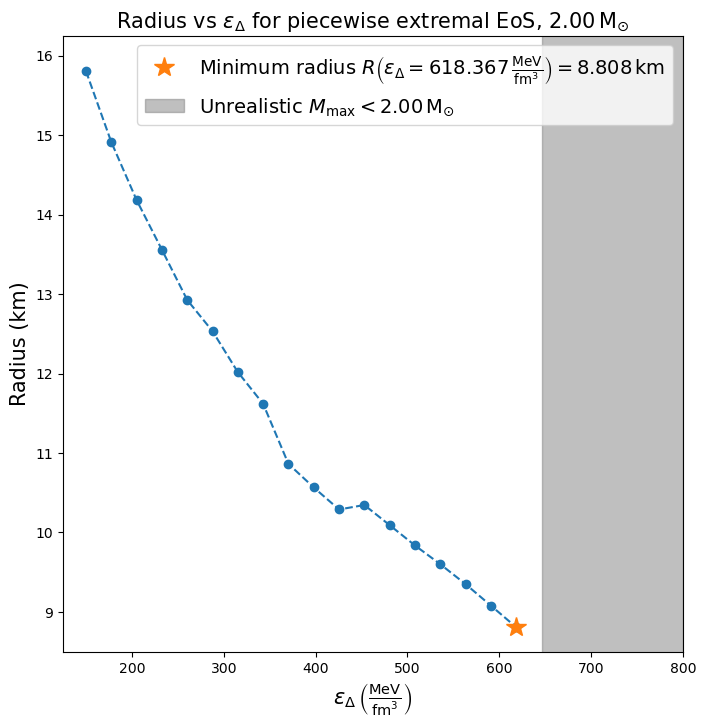

In [37]:
# Plotting radius vs EoS parameter

fig, ax = plt.subplots(figsize = (8, 8))

ax.set_title(r"Radius of $2.00\,\mathrm{M}_{\odot}$ neutron stars, $c_{s,\,\mathrm{upper}}=1$",
             fontsize = 15
            );

ax.set_xlabel(r"$\epsilon_{\Delta}\,\left(\frac{\mathrm{MeV}}{\mathrm{fm}^3}\right)$", fontsize = 15);
ax.set_ylabel("Radius (km)", fontsize = 15);
ax.set_xlim(125, 800);
ax.set_ylim(8.5, 16.25);
ax.plot(epsilon_delta_2, radii, "--o");

# Noting minimum radius and corresponding epsilon_delta value, in km and MeV / fm^3 respectively (found from data below)
min_radius = 8.808
epsilon_delta_constraint = 618.367

ax.plot(epsilon_delta_constraint,
        min_radius,
        marker = "*",
        linestyle = "",
        markersize = 15,
        label = r"Minimum radius $R\left(\epsilon_{\Delta}=618.367\,\frac{\mathrm{MeV}}{\mathrm{fm}^3}\right)=8.808\,\mathrm{km}$"
       );

# Noting unrealistic mass region
ax.fill([645.918, 800, 800, 645.918],
        [8, 8, 16.5, 16.5],
        color = "grey",
        alpha = 0.5,
        label = "Unrealistic $M_{\mathrm{max}}<2.00\,\mathrm{M}_{\odot}$"
       );

ax.legend(fontsize = 14);

# Saving plots if result is notable
plt.savefig("radius_vs_epsilon_delta.jpg", bbox_inches = "tight");
plt.savefig("radius_vs_epsilon_delta.pdf", bbox_inches = "tight");

In [27]:
# Adding units
epsilon_delta_2 = epsilon_delta_2 * u.MeV / (1 * u.fm) ** 3
radii = radii * u.km

In [28]:
# Finding minimum radius and EoS parameter
min_radius = np.min(radii)
epsilon_delta_constraint = epsilon_delta_2[np.where(radii == min_radius)[0][0]]
print(f"The minimum radius of a 2.00 solar mass neutron star is {min_radius:.3f}.")
print(f"The value of epsilon_delta that minimizes the radius of a 2.00 solar mass neutron star is {epsilon_delta_constraint:.3f}.")

The minimum radius of a 2.00 solar mass neutron star is 8.808 km.
The value of epsilon_delta that minimizes the radius of a 2.00 solar mass neutron star is 618.367 MeV / fm3.


In [29]:
# Printing the results
print("radii:")
print(radii)
print("epsilon_delta_2:")
print(epsilon_delta_2)
print("epsilon_delta_sub_2:")
print(epsilon_delta_sub_2)

radii:
[15.80425336 14.91201563 14.182255   13.55692717 12.92526509 12.53221301
 12.01800029 11.61868911 10.86291522 10.56633135 10.28961551 10.34569244
 10.0923393   9.83699624  9.6010888   9.35030528  9.08004747  8.80819972] km
epsilon_delta_2:
[150.         177.55102041 205.10204082 232.65306122 260.20408163
 287.75510204 315.30612245 342.85714286 370.40816327 397.95918367
 425.51020408 453.06122449 480.6122449  508.16326531 535.71428571
 563.26530612 590.81632653 618.36734694] MeV / fm3
epsilon_delta_sub_2:
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 645.91836735, 673.46938776, 701.02040816, 728.57142857, 756.12244898, 783.67346939, 811.2244898, 838.7755102, 866.32653061, 893.87755102, 921.42857143, 948.97959184, 976.53061224, 1004.08163265, 1031.63265306, 1059.18367347, 1086.73469388, 1114.28571429, 1141.83673469, 1169.3877551, 1196.93877551, 1224.48979592, 1252.04081633, 1279.59183673, 1307.14285714, 1334.69387755, 

In [ ]:
# Calculating runtime
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")